# Capítulo 3 - Analisando os dados

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
#basics
import sys,os
sys.path.insert(1, os.path.dirname(os.getcwd()))

#utils
import paths

#main libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option("display.precision", 4)
%matplotlib inline

#model Libraries
from sklearn import utils
from sklearn import preprocessing

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GroupKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

#Light GBM
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor
from lightgbm import LGBMRanker

In [9]:
#private modules 
#data
from src.data import make_dataset

#utils
from src.utils import memory_usage

#models
from src.models import train_model
from src.models import evaluation

#validation
from src.validation import metrics
from src.validation import metrics_description

In [10]:
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor

from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor
from lightgbm import LGBMRanker

from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import XGBRanker

# Dados

In [11]:
%%time
df_training,features,target = make_dataset.get_data(nrows=None,
                                                    low_memory=True, 
                                                    dataset="training", 
                                                    feather=True)

low memory activated
Memory usage after optimization is: 309.15 MB
Decreased by 49.1%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501808 entries, 0 to 501807
Columns: 314 entries, id to target_kazutsugi
dtypes: float16(311), int32(1), object(2)
memory usage: 307.2+ MB
None
CPU times: user 51 s, sys: 1min 13s, total: 2min 4s
Wall time: 3min 35s


In [47]:
%%time
df_validation,features,target = make_dataset.get_data(nrows=None,
                                                    low_memory=False, 
                                                    dataset="validation", 
                                                    feather=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106895 entries, 0 to 106894
Columns: 314 entries, id to target_kazutsugi
dtypes: float32(311), int32(1), object(2)
memory usage: 128.9+ MB
None
CPU times: user 534 ms, sys: 847 ms, total: 1.38 s
Wall time: 975 ms


In [16]:
print(memory_usage.memory())

Available memory (%): 26.99270248413086
None


validation

In [9]:
df_validation = df_tournament[df_tournament.data_type == 'validation']
df_validation['era'] = df_validation.loc[:, 'era'].str[3:].astype('int32')

### Nomi

In [26]:
%%time
df_training,df_validation,features,target = \
                          make_dataset.get_data_nomi(nrows=None,
                                                    low_memory=True, 
                                                    dataset="nomi", 
                                                    feather=True)

low memory activated
Memory usage after optimization is: 376.17 MB
Decreased by 49.1%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608703 entries, 0 to 608702
Columns: 315 entries, id to target_nomi
dtypes: float16(312), int32(1), object(2)
memory usage: 373.8+ MB
None
CPU times: user 1min 1s, sys: 1min 16s, total: 2min 17s
Wall time: 3min 12s


## Conjunto de dados (treino)

In [31]:
df_training.head() #.iloc[:,:-1]

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target_kazutsugi
0,n000315175b67977,1,train,0.00,0.50,0.25,0.00,0.5,0.25,0.25,...,1.00,1.00,0.75,0.50,0.75,0.50,1.00,0.50,0.75,0.75
1,n0014af834a96cdd,1,train,0.00,0.00,0.00,0.25,0.5,0.00,0.00,...,1.00,1.00,0.00,0.00,0.75,0.25,0.00,0.25,1.00,0.25
2,n001c93979ac41d4,1,train,0.25,0.50,0.25,0.25,1.0,0.75,0.75,...,0.25,0.50,0.00,0.00,0.50,1.00,0.00,0.25,0.75,0.00
3,n0034e4143f22a13,1,train,1.00,0.00,0.00,0.50,0.5,0.25,0.25,...,1.00,1.00,0.75,0.75,1.00,1.00,0.75,1.00,1.00,0.00
4,n00679d1a636062f,1,train,0.25,0.25,0.25,0.25,0.0,0.25,0.50,...,0.75,0.75,0.25,0.50,0.75,0.00,0.50,0.25,0.75,0.75


In [13]:
# The features are grouped together into 6 types
feature_groups = {
    g: [c for c in df_training if c.startswith(f"feature_{g}")]
    for g in ["intelligence", "wisdom", "charisma", "dexterity", "strength", "constitution"]
}

In [14]:
for group, f_list in feature_groups.items():
    print(f_list[-1])

feature_intelligence12
feature_wisdom46
feature_charisma86
feature_dexterity14
feature_strength38
feature_constitution114


### Algumas features dentro do mesmo grupo são altamente correlacionadas

In [19]:
feature_intelligence = [c for c in df_training if c.startswith("feature_intelligence")]

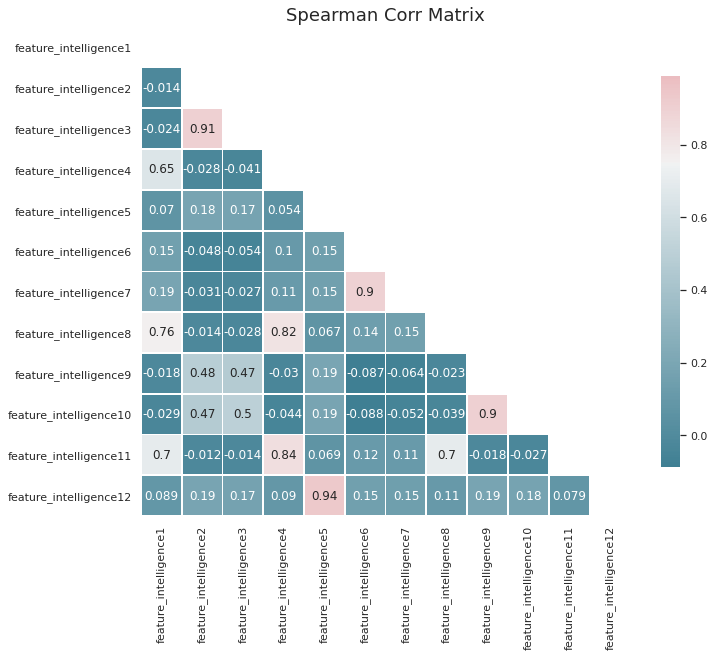

In [19]:
visualize.plot_corr_matrix(df_training[feature_intelligence])

In [33]:
print()
print()
print()
print()

### Essa correlação muda com o passar das eras

Comparamos a correlação de **pearson** nas primeira metade (eras 1-60), com a segunda metade (era 61-120)

In [18]:
eras = df_training.era
df1 = df_training[eras<=eras.median()]
df2 = df_training[eras>eras.median()]

In [20]:
corr1 = df1[feature_intelligence].corr().unstack()
corr1 = corr1[corr1.index.get_level_values(0) < corr1.index.get_level_values(1)]

In [21]:
corr2 = df2[feature_intelligence].corr().unstack()
corr2 = corr2[corr2.index.get_level_values(0) < corr2.index.get_level_values(1)]

In [24]:
tdf = pd.DataFrame({
    "corr1": corr1,
    "corr2": corr2,
})
tdf["corr_diff"] = tdf.corr2 - tdf.corr1
tdf.sort_values(by="corr_diff").head().style.set_properties(**{'font-size': '20 pt'})

#### O relacionamento entre as variáveis é inconsistente

## Sobre o target

* Proporção dos valores do target é similar ao *Numerai Signals*
* A Quantidade de ações monitorada dentro das 120 eras (mensais) é variável.

COmplementar a imagem do target signals na area de trabalho

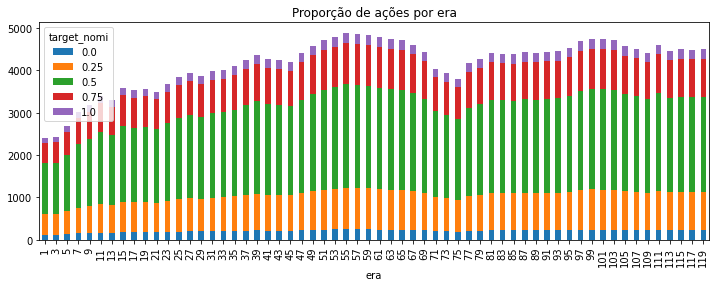

In [40]:
targets = df_training.loc[:, ['era', target]]
pivot_target = targets.groupby(['era', target]).apply(lambda x: len(x)).reset_index(1).pivot(columns=target,values=0)
pivot_target.iloc[::2].plot(kind='bar', stacked=True, figsize=(12,4), title='Proporção de ações por era');

## Algumas features possuem correlação com o target

In [13]:
df = df_training.copy()
eras = df_training.era

In [14]:
# The models should be scored based on the rank-correlation (spearman) with the target
def numerai_score(y_true, y_pred):
    rank_pred = y_pred.groupby(eras).apply(lambda x: x.rank(pct=True, method="first"))
    return np.corrcoef(y_true, rank_pred)[0,1]

# It can also be convenient while working to evaluate based on the regular (pearson) correlation
def correlation_score(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0,1]

In [35]:
feature_scores = {
    feature: numerai_score(df[target], df[feature])
    for feature in features
}

In [45]:
pd.Series(feature_scores).sort_values(ascending=False)

feature_strength34     0.0123
feature_strength14     0.0115
feature_charisma37     0.0110
feature_charisma18     0.0108
feature_charisma76     0.0107
                        ...  
feature_dexterity11   -0.0102
feature_charisma69    -0.0103
feature_dexterity4    -0.0110
feature_dexterity6    -0.0111
feature_dexterity7    -0.0115
Length: 310, dtype: float64

### Lembre-se que a relação sinal-ruído é extramamente baixa

### Como uma feature se comporta com relação ao target por era

Lembrete: Uma feature é um indicador financeiro

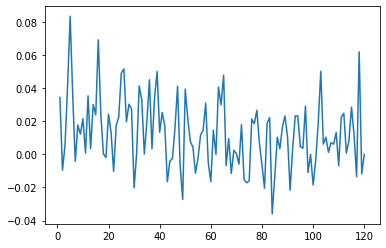

In [39]:
# Single features do not work consistently though
by_era_correlation = pd.Series({
    era: np.corrcoef(tdf['target_kazutsugi'], tdf["feature_strength34"])[0,1]
    for era, tdf in df.groupby(eras)
})
by_era_correlation.plot();

#### Analisando a média movel de 10 eras

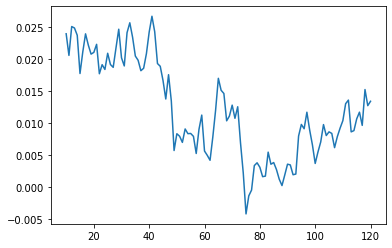

In [38]:
# With a rolling 10 era average you can see some trends
by_era_correlation.rolling(10).mean().plot();

### Conclusão: Não podemos confiar demais em um grupo pequeno de features

## Que  problema estamos resolvendo?

<img src="https://github.com/nicholasrichers/dissertacao/blob/master/references/figures/cap3/integration_test.png?raw=true" width=800 />

*Fonte: https://numer.ai/integration_test*

spearman como é, coloque a imagem da wiki

entao estamos resolvendo um problema de ranqueamento

criar bolotas

### Baseline

Que modelo ele usa? (*)

In [56]:
print("XGBRegressor(n_estimators=2000, learning_rate=0.01, max_depth=5, colsample_bytree=0.1)")

XGBRegressor(n_estimators=2000, learning_rate=0.01, max_depth=5, colsample_bytree=0.1)


Lembrando que o target possui os valores ...

Porque regressão?

Utilizaremos 3 dos melhores modelos de machine learning do mercado e vamos comparar as implementações de classificação, regressão e ranqueamento.

In [ ]:
model_name = [
              "XGBClassifier"
              ,"XGBRegressor"
              ,"XGBRanker"
              ,"LGBMClassifier"
              ,"LGBMRegressor"
              ,"LGBMRanker"
              ,"CatBoostClassifier"
              ,"CatBoostRegressor"              
]

In [ ]:
est = 2000
models = [
    XGBClassifier(max_depth=5, learning_rate=0.01, n_estimators=est, n_jobs=-1, colsample_bytree=0.1, tree_method='gpu_hist', gpu_id=0),
    XGBRegressor(max_depth=5, learning_rate=0.01, n_estimators=est, n_jobs=-1, colsample_bytree=0.1, tree_method='gpu_hist', gpu_id=0),
    XGBRanker(max_depth=5, learning_rate=0.01, n_estimators=est, n_jobs=-1, colsample_bytree=0.1, tree_method='gpu_hist', gpu_id=0)
] +  [
    LGBMClassifier(max_depth=5, learning_rate=0.01, n_estimators=est, n_jobs=-1, colsample_bytree=0.1, num_leaves=32, device_type = "gpu"),
    LGBMRegressor(max_depth=5, learning_rate=0.01, n_estimators=est, n_jobs=-1, colsample_bytree=0.1, num_leaves=32, device_type = "gpu"),
    LGBMRanker(max_depth=5, learning_rate=0.01, n_estimators=est, n_jobs=-1, colsample_bytree=0.1, num_leaves=32, device_type = "gpu")
] +  [
    CatBoostClassifier(max_depth=5, learning_rate=0.01, n_estimators=est, task_type='GPU'),
    CatBoostRegressor(max_depth=5, learning_rate=0.01, n_estimators=est, task_type='GPU')
]

In [ ]:
results = dict()
from time import time

for i,model in enumerate(models):
    model_res = dict()
    print(" -- ", model)
    start = time()
    if model_name[i] == "XGBRanker" or model_name[i] == "LGBMRanker":
      model.fit(training_data[features], training_data[target], group=group)
    else:
      model.fit(training_data[features], training_data[target])
    elapsed = time() - start
    model_res["outsample"] = numerai_score(df2[target], pd.Series(model.predict(df2[features]).reshape(1,-1)[0], index=df2.index))
    model_res["insample"] = numerai_score(df1[target], pd.Series(model.predict(df1[features]).reshape(1,-1)[0], index=df1.index))
    model_res["time_elapsed(s)"] = elapsed
    print(
        #f"outsample: {model_res["outsample"]}, insample: {model_res["insample"]}"
    )
    print()
    results[model_name[i]] = model_res
    file_name = 'baseline_'+ model_name[i] +'.pkl'
    dump(model, file_name)

res = pd.DataFrame.from_dict(results).T
pd.set_option("display.precision", 4)

final_results = res.sort_values(by=['outsample'], ascending=False)
#final_results.to_csv("results_baseline.csv", index=True)

 --  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.1, gamma=0, gpu_id=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)
[16:58:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.




In [50]:
#res.sort_values(by=['time_elapsed(s)'])
results = pd.read_csv("../../reports/results_baseline.csv")

In [ ]:
results.sort_values(by=['outsample'], ascending=False)

,outsample,insample,time_elapsed_GPU(s),time_elapsed(s)
LGBMRegressor,0.0447,0.2677,23.8324,62.3275
XGBRanker,0.0442,0.2021,67.5707,469.0444
XGBRegressor,0.0440,0.2667,37.2466,445.6100
LGBMClassifier,0.0305,0.2070,137.1966,301.8254
XGBClassifier,0.0302,0.1648,232.9470,2172.2911
CatBoostClassifier,0.0271,0.0959,19.0138,1193.6433
CatBoostRegressor,0.0267,0.0949,9.2403,209.8839
LGBMRanker,0.0150,0.0647,6092.7200,16133.8554


#### Metricas Classificacao 

In [ ]:
preds = models["LGBMClassifier"].predict(df_validation[features])

              precision    recall  f1-score   support

           0       0.27      0.28      0.28     21352
           1       0.23      0.15      0.18     21363
           2       0.27      0.36      0.31     21474
           3       0.22      0.15      0.18     21362
           4       0.27      0.35      0.30     21344

    accuracy                           0.26    106895
   macro avg       0.25      0.26      0.25    106895
weighted avg       0.25      0.26      0.25    106895



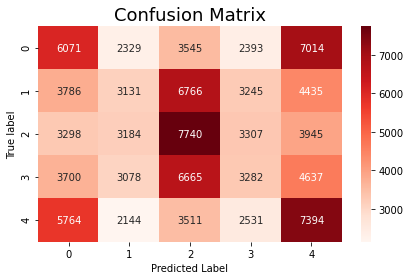

In [ ]:
evaluation.plot_confusion_matrix(lab_enc.fit_transform(df_validation[target]), preds/4)

array([[ 1.        , -0.81393351, -0.8942065 , -0.88654085,  0.78328667],
       [-0.81393351,  1.        ,  0.80874765,  0.72378902, -0.89877694],
       [-0.8942065 ,  0.80874765,  1.        ,  0.77462933, -0.90867348],
       [-0.88654085,  0.72378902,  0.77462933,  1.        , -0.80042416],
       [ 0.78328667, -0.89877694, -0.90867348, -0.80042416,  1.        ]])

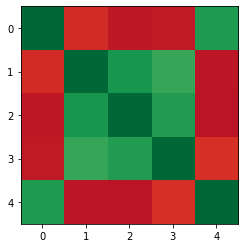

In [ ]:
# The first and last class are highly correlated
corrs=np.corrcoef(model.predict_proba(df_validation[features]).T)
plt.imshow(corrs, vmin=-1, vmax=1, cmap="RdYlGn")
corrs

## Falar sobre validação
##  Random cross-validation will look much better than cross-validating by era

Even for a simple linear model, taking a random shuffle reports a correlation of 4.3%, but a time series split reports a lower score of 3.4%

In [58]:
from sklearn import (
    feature_extraction, feature_selection, decomposition, linear_model,
    model_selection, metrics, svm
)

In [59]:
crossvalidators = [
    model_selection.KFold(5),
    model_selection.KFold(5, shuffle=True),
    model_selection.GroupKFold(5),
    model_selection.TimeSeriesSplit(5)
]

In [60]:
def correlation_score(y_true, y_pred):
    return numpy.corrcoef(y_true, y_pred)[0,1]

In [ ]:
for cv in crossvalidators:
    print(cv)
    print(np.mean(
            model_selection.cross_val_score(
            linear_model.LinearRegression(),
            df[features],
            df[target],
            cv=cv,
            n_jobs=1,
            groups=eras,
            scoring=metrics.make_scorer(correlation_score, greater_is_better=True)
        )))
    print()

KFold(n_splits=5, random_state=None, shuffle=False)
0.03658489467457003

KFold(n_splits=5, random_state=None, shuffle=True)
0.04360860798952288

GroupKFold(n_splits=5)
0.038069863851659315

TimeSeriesSplit(max_train_size=None, n_splits=5)
0.033943838232674675



## Eras can be more or less applicable to other eras
You can test this be splitting the eras into blocks of 10, training on each block, and evaluating on each other block.

In [68]:
eras10 = (eras // 10) * 10
eras10.value_counts()

50     48186
60     46831
100    46107
90     45609
110    45070
80     43971
40     43439
30     41101
70     40403
20     37444
10     34600
0      24515
120     4532
Name: era, dtype: int64

In [69]:
from sklearn.linear_model import LinearRegression
results10 = []
for train_era, tdf in df[eras10<120].groupby(eras10):
    print(train_era)
    model = linear_model.LinearRegression()
    model.fit(tdf[features], tdf[target])
    for test_era, tdf in df[eras10<120].groupby(eras10):
        results10.append([
            train_era,
            test_era,
            correlation_score(tdf[target], model.predict(tdf[features]))
        ])

0
10
20
30
40
50
60
70
80
90
100
110


In [71]:
results_df = pd.DataFrame(
    results10,
    columns=["train_era", "test_era", "score"]
).pivot(index="train_era", columns="test_era", values="score")
results_df

test_era,0,10,20,30,40,50,60,70,80,90,100,110
train_era,,,,,,,,,,,,
0,0.1462,0.0330,0.0345,0.0297,0.0216,0.0075,-0.0004,0.0318,0.0274,0.0316,0.0190,0.0006
10,0.0427,0.1153,0.0294,0.0299,0.0330,0.0055,0.0078,0.0233,0.0205,0.0301,0.0205,0.0145
20,0.0421,0.0343,0.1131,0.0368,0.0163,0.0060,-0.0016,0.0195,0.0118,0.0265,0.0216,0.0090
30,0.0368,0.0342,0.0394,0.1101,0.0399,0.0214,0.0157,0.0330,0.0259,0.0356,0.0130,0.0080
40,0.0344,0.0417,0.0200,0.0403,0.1000,0.0151,0.0082,0.0280,0.0227,0.0289,0.0117,0.0154
50,0.0155,0.0107,0.0069,0.0248,0.0157,0.1051,0.0129,0.0116,0.0050,0.0189,0.0134,0.0170
60,0.0065,0.0154,0.0035,0.0193,0.0124,0.0112,0.1015,0.0131,0.0089,-0.0027,0.0071,0.0120
70,0.0350,0.0259,0.0225,0.0284,0.0233,0.0022,0.0087,0.1211,0.0284,0.0301,0.0167,0.0036
80,0.0396,0.0263,0.0107,0.0220,0.0173,0.0025,0.0053,0.0285,0.1040,0.0284,0.0157,0.0062


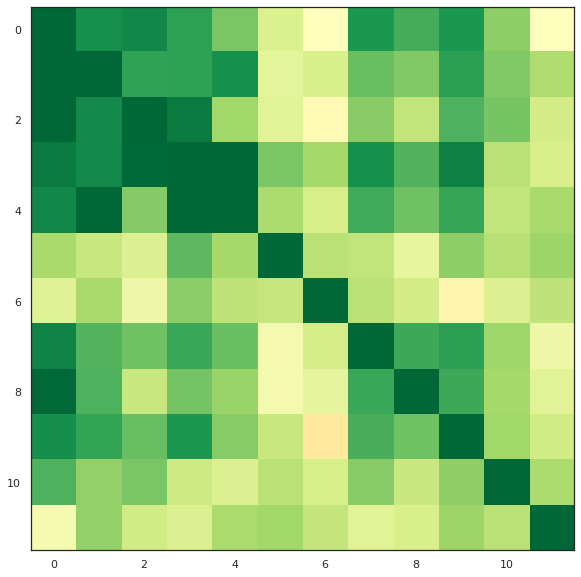

In [78]:
# Each row here is the training block of eras, each column is a testing block of eras.
# Note that there is a period in the middle that does not seem to be relevant to other eras, and the
#  overall performance seems to decrease a bit over time.
plt.figure(figsize=(10,10))
plt.imshow(results_df, vmin=-0.04, vmax=0.04, cmap="RdYlGn")


Here is an advanced paper that talks about generalization.
Eras can be thought about in the same way that "distributions" or "environments" are talked about here
https://arxiv.org/pdf/1907.02893.pdf

# NR_RIO

falar brevemente e e mostrar os resultados


falar tbm dos dataset de validacaoe  tournament, usar a ia


resumao da competicao em si

# Create Slides

In [41]:
!jupyter nbconvert Cap3_Dados.ipynb --to slides --template output_toggle  --SlidesExporter.reveal_scroll=True --SlidesExporter.reveal_theme=white #--post serve

[NbConvertApp] Converting notebook Cap3_Dados.ipynb to slides
[NbConvertApp] Writing 574280 bytes to Cap3_Dados.slides.html


In [ ]:
#configuração da dimensões da tela de apresentação
from notebook.services.config import ConfigManager
cm = ConfigManager()

#defina as dimensões da apresentação.
cm.update('livereveal', {
              'width': 1024,
              'height': 768,
              'scroll': True,
              'transition': 'slide',
              "theme": "white",
               "autolaunch": False
         })


#"rise": {"enable_chalkboard": True}
# themes path /Users/nicholasrichers/Documents/virtualenvs/numerai_env/share/jupyter/nbextensions/rise/reveal.js/css/theme

In [ ]:
#df_training.iloc[0:2,0:2].to_markdown()